# Part 1 - Exploratory Data Analysis

In [1]:
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
df=pd.read_json('logins.json')

In [3]:
df.dtypes

login_time    datetime64[ns]
dtype: object

In [4]:
df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [5]:
df.tail()

,login_time
93137,1970-04-13 18:50:19
93138,1970-04-13 18:43:56
93139,1970-04-13 18:54:02
93140,1970-04-13 18:57:38
93141,1970-04-13 18:54:23


Data is from Jan 1st 1970 20:00:00 to Apr 13th 1970 18:54:23. 

In [6]:
df.shape

(93142, 1)

In [7]:
df.isnull().any()

login_time    False
dtype: bool

In [8]:
df['demand']=df.index

In [9]:
df2=df.resample('15min', on='login_time').sum()

In [10]:
df2.head()

,demand
login_time,
1970-01-01 20:00:00,6
1970-01-01 20:15:00,25
1970-01-01 20:30:00,113
1970-01-01 20:45:00,132
1970-01-01 21:00:00,25


In [11]:
df2.shape

(9788, 1)

In [12]:
df2.describe()

,demand
count,9.788000e+03
mean,4.431620e+05
std,5.697936e+05
min,0.000000e+00
25%,6.954900e+04
50%,2.268785e+05
75%,6.060472e+05
max,5.558670e+06


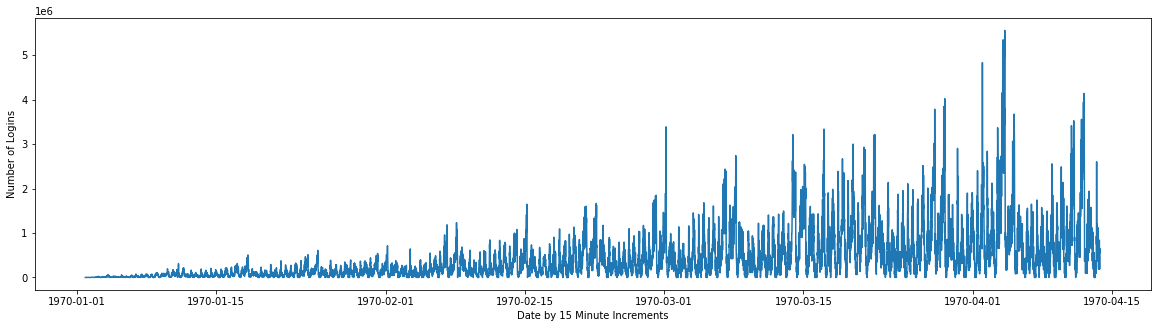

In [13]:
plt.figure(figsize=(20, 5))
plt.plot(df2.index, df2.demand)
plt.xlabel('Date by 15 Minute Increments')
plt.ylabel('Number of Logins')
plt.show()

The mean number of logins per 15 minute increment is 443,162, but the error is larger. The number of logins exponentially increased overall. There seems to be a semi-monthly (almost?) pattern. It might make more sense to visualize other time intervals.

In [14]:
df3=df.resample('1H', on='login_time').sum()

In [15]:
df3.head()

,demand
login_time,
1970-01-01 20:00:00,276
1970-01-01 21:00:00,254
1970-01-01 22:00:00,924
1970-01-01 23:00:00,4764
1970-01-02 00:00:00,7318


In [16]:
df3.describe()

,demand
count,2.447000e+03
mean,1.772648e+06
std,2.171944e+06
min,0.000000e+00
25%,3.127505e+05
50%,9.423370e+05
75%,2.478568e+06
max,1.978852e+07


In [17]:
df3[df3.demand==0]

,demand
login_time,
1970-01-08 15:00:00,0
1970-02-19 08:00:00,0


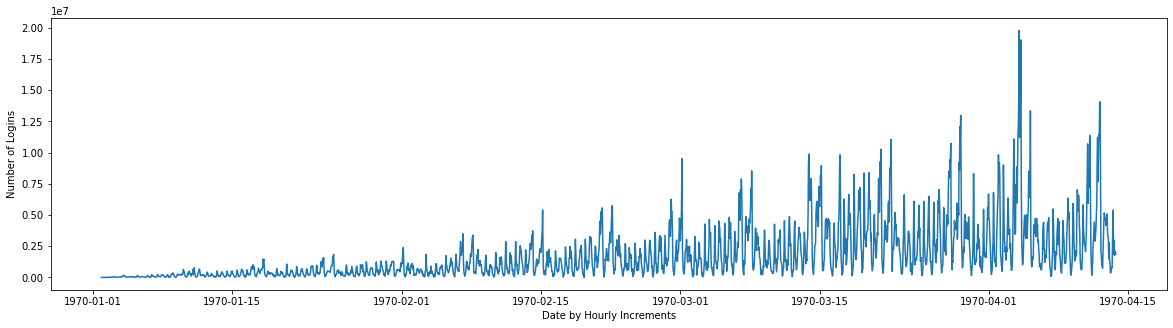

In [18]:
plt.figure(figsize=(20, 5))
plt.plot(df3.index, df3.demand)
plt.xlabel('Date by Hourly Increments')
plt.ylabel('Number of Logins')
plt.show()

In [19]:
df3=df3.groupby(lambda x: x.hour).sum()

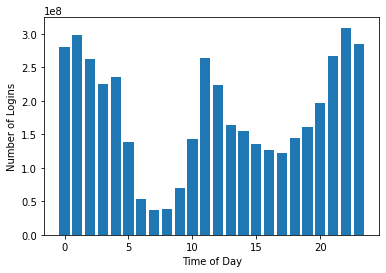

In [20]:
plt.bar(df3.index, height=df3.demand)
plt.xlabel('Time of Day')
plt.ylabel('Number of Logins')
plt.show()

Demand peaks highest at 9pm to 2am and again at 11am. The lowest number of logins occur from 6am to 9am. 

In [21]:
df4=df.resample('1D', on='login_time').sum()

In [22]:
df4=df4.groupby(lambda x: x.day).sum()

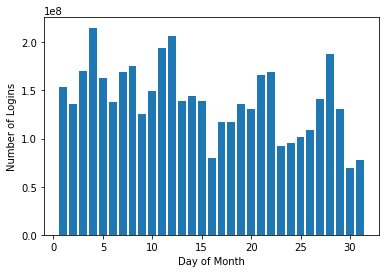

In [23]:
plt.bar(df4.index, height=df4.demand)
plt.xlabel('Day of Month')
plt.ylabel('Number of Logins')
plt.show()

Number of logins are highest at the beginning of the month than at the end of the month.

In [24]:
df5=df.resample('1M', on='login_time').sum()

In [25]:
df5

,demand
login_time,
1970-01-31,225536941
1970-02-28,828395977
1970-03-31,2116893893
1970-04-30,1166842700


In [26]:
df5['month']=['January', 'February', 'March', 'April (Until the 13th)']

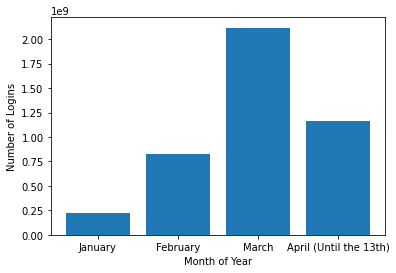

In [27]:
plt.bar(df5.month, height=df5.demand)
plt.xlabel('Month of Year')
plt.ylabel('Number of Logins')
plt.show()

The number of logins exponentially increased from January to March. There was not enough data to account for the whole month of April. 

# Part 2 - Experiment and Metrics Design

The mean difference in percentage of time spent on weekdays in Ultimate Gothem during the day before and after reimbursement, and in Ultimate Metropolis at night before and after reimbursement. The imbalance in activity in each city may not necessarily be due to supply but rather demand. If it is due to demand, the reimbursement may even encourage drivers to drive over to serve the city with more activity/demand, instead of staying available in the city that is less busier.

We can choose to test with the same group of drivers before and after reimbursement, and try to use the same time periods and city districts for sampling, avoiding holidays and weekends (eg. same day of week by 2 hour increments), to control for rider request volume. Collect data each trip: driver id, home city, timestamps and locations (city) for the start & end of the trip, total trip distance, toll gate usage (True or False and timestamp), and whether it occurred before or after reimbursement. Total trip time can be calculated from timestamps, and split into time spent in each city if applicable based on timestamps colleted at the toll gate. The time spent in each city can be divided by the total trip time. Then we can use a t-test to confirm if there is a significant difference in means of percent trip time driving in Ultimate Gothem during the day compared to total trip time, and in Ultimate Metropolis during the night.

We can also choose to divide the group of drivers into two and reimburse only one group. This method helps control for the difference in sampling periods above but does not control for individual driver preference. 

# Part 3 - Predictive Modeling

In [28]:
udf=pd.read_json('ultimate_data_challenge.json')

In [29]:
udf.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [30]:
udf.shape

(50000, 12)

In [31]:
udf.isnull().any()

city                      False
trips_in_first_30_days    False
signup_date               False
avg_rating_of_driver       True
avg_surge                 False
last_trip_date            False
phone                      True
surge_pct                 False
ultimate_black_user       False
weekday_pct               False
avg_dist                  False
avg_rating_by_driver       True
dtype: bool

In [32]:
udf.dropna(inplace=True)

In [33]:
udf.shape

(41445, 12)

In [34]:
udf.shape[0]/50000

0.8289

82.89% of the observed users were retained. 

In [35]:
udf.dtypes

city                       object
trips_in_first_30_days      int64
signup_date                object
avg_rating_of_driver      float64
avg_surge                 float64
last_trip_date             object
phone                      object
surge_pct                 float64
ultimate_black_user          bool
weekday_pct               float64
avg_dist                  float64
avg_rating_by_driver      float64
dtype: object

In [36]:
udf.signup_date=pd.to_datetime(udf.signup_date)

In [37]:
udf.last_trip_date=pd.to_datetime(udf.last_trip_date)

In [38]:
udf.dtypes

city                              object
trips_in_first_30_days             int64
signup_date               datetime64[ns]
avg_rating_of_driver             float64
avg_surge                        float64
last_trip_date            datetime64[ns]
phone                             object
surge_pct                        float64
ultimate_black_user                 bool
weekday_pct                      float64
avg_dist                         float64
avg_rating_by_driver             float64
dtype: object

In [39]:
udf.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,41445.000000,41445.000000,41445.000000,41445.000000,41445.000000,41445.000000,41445.000000
mean,2.609675,4.601720,1.073822,8.898709,61.254897,5.460046,4.776446
std,4.059336,0.616104,0.198747,18.322061,34.813848,5.145174,0.404606
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.300000,1.000000,0.000000,37.500000,2.420000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.780000,5.000000
75%,3.000000,5.000000,1.070000,11.100000,100.000000,6.490000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,79.690000,5.000000


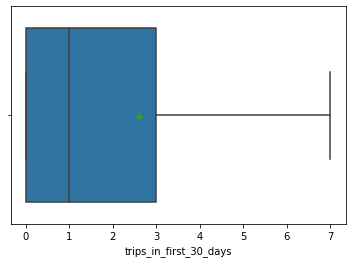

In [40]:
sns.boxplot(x=udf.trips_in_first_30_days, showfliers=False, showmeans=True)
plt.show()

In the first month, users took 2.6 trips on average.

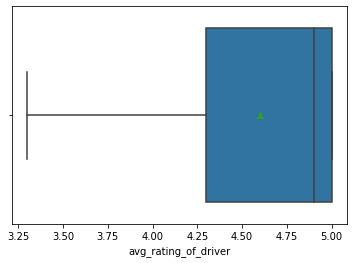

In [41]:
sns.boxplot(x=udf.avg_rating_of_driver, showfliers=False, showmeans=True)
plt.show()

75% of ratings of drivers are above 4.3. 

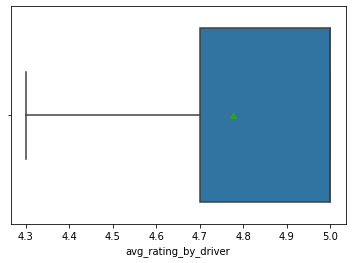

In [42]:
sns.boxplot(x=udf.avg_rating_by_driver, showfliers=False, showmeans=True)
plt.show()

Ratings given by drivers are higher.

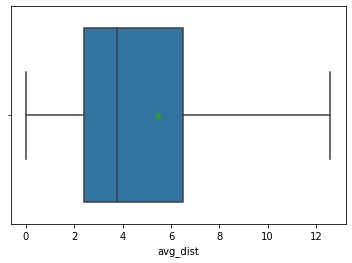

In [43]:
sns.boxplot(x=udf.avg_dist, showfliers=False, showmeans=True)
plt.show()

Most people travelled about 2.5 to 6.5 miles per trip in the first 30 days after signup. 

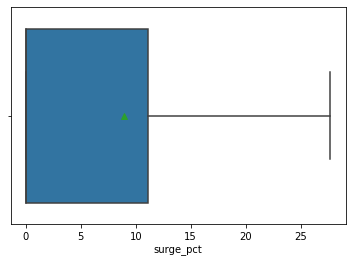

In [44]:
sns.boxplot(x=udf.surge_pct, showfliers=False, showmeans=True)
plt.show()

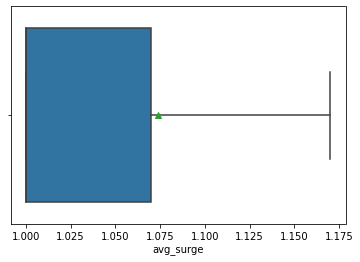

In [45]:
sns.boxplot(x=udf.avg_surge, showfliers=False, showmeans=True)
plt.show()

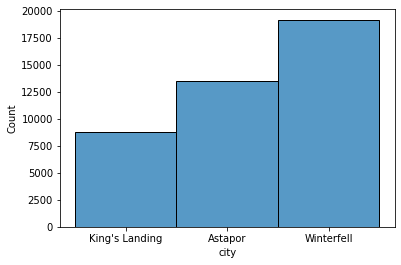

In [46]:
sns.histplot(x=udf.city)
plt.show()

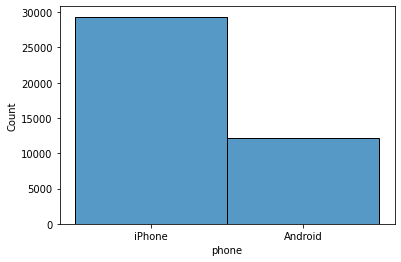

In [47]:
sns.histplot(x=udf.phone)
plt.show()

iPhone users dominate the user database.

In [48]:
udf.ultimate_black_user.value_counts()

False    25526
True     15919
Name: ultimate_black_user, dtype: int64

In [49]:
udf[udf['surge_pct']==100]

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
32,Winterfell,1,2014-01-05,4.0,2.00,2014-06-10,iPhone,100.0,False,100.0,10.01,5.0
42,Winterfell,1,2014-01-25,4.0,1.50,2014-01-26,Android,100.0,False,0.0,5.72,5.0
47,Winterfell,1,2014-01-18,5.0,1.25,2014-01-19,iPhone,100.0,False,0.0,3.61,5.0
50,Winterfell,0,2014-01-04,5.0,1.25,2014-02-15,Android,100.0,False,0.0,3.25,5.0
59,Astapor,1,2014-01-25,5.0,1.25,2014-03-29,iPhone,100.0,False,0.0,6.05,4.5
...,...,...,...,...,...,...,...,...,...,...,...,...
49885,Winterfell,1,2014-01-04,4.0,1.75,2014-01-05,iPhone,100.0,False,0.0,1.89,5.0
49894,Winterfell,0,2014-01-11,5.0,1.25,2014-02-21,iPhone,100.0,False,100.0,5.18,5.0
49928,Astapor,1,2014-01-04,5.0,2.00,2014-01-11,iPhone,100.0,False,100.0,0.58,5.0
49974,Winterfell,1,2014-01-05,5.0,2.00,2014-01-18,iPhone,100.0,False,100.0,4.63,5.0


In [50]:
udf.signup_date.describe(datetime_is_numeric=True)

count                            41445
mean     2014-01-16 11:13:33.811075072
min                2014-01-01 00:00:00
25%                2014-01-09 00:00:00
50%                2014-01-17 00:00:00
75%                2014-01-24 00:00:00
max                2014-01-31 00:00:00
Name: signup_date, dtype: object

In [51]:
udf.last_trip_date.describe(datetime_is_numeric=True)

count                            41445
mean     2014-04-24 13:50:17.850162944
min                2014-01-01 00:00:00
25%                2014-02-24 00:00:00
50%                2014-05-16 00:00:00
75%                2014-06-20 00:00:00
max                2014-07-01 00:00:00
Name: last_trip_date, dtype: object

In [52]:
udf['time']=udf.last_trip_date-udf.signup_date

In [53]:
udf.time.describe()

count                         41445
mean     98 days 02:36:44.039087948
std      61 days 04:39:07.898461939
min                 0 days 00:00:00
25%                38 days 00:00:00
50%               118 days 00:00:00
75%               152 days 00:00:00
max               181 days 00:00:00
Name: time, dtype: object

All users signed up in January. The longest time period between the sign up date and the last trip date was 181 days which may be a problem..

In [54]:
udf['greater_than_180d']=(udf.time>='180d').map({False: 0., True: 1.})

In [55]:
udf.greater_than_180d.value_counts()

0.0    41364
1.0       81
Name: greater_than_180d, dtype: int64

Assuming a month has 30 days, we divided the data into two sets of users who were active for less than 6 months vs. who were active for longer. It looks like only 81 users weren't active for 6 months or longer, so we are working with a very unbalanced dataset.

In [56]:
udf.city.value_counts()

Winterfell        19161
Astapor           13509
King's Landing     8775
Name: city, dtype: int64

In [57]:
udf.city=udf.city.map({"King's Landing":0., 'Astapor':1., 'Winterfell':2.})

In [58]:
udf.phone=udf.phone.map({'iPhone':0., 'Android':1.})

In [59]:
udf.ultimate_black_user=udf.ultimate_black_user.map({True:1., False:0.})

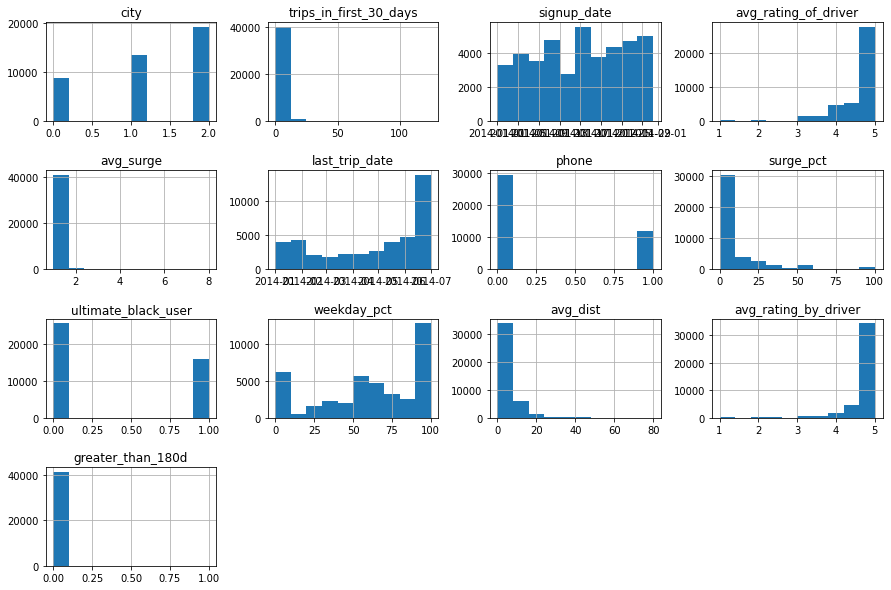

In [60]:
udf.hist(figsize=(15,10))
plt.subplots_adjust(hspace=0.5);

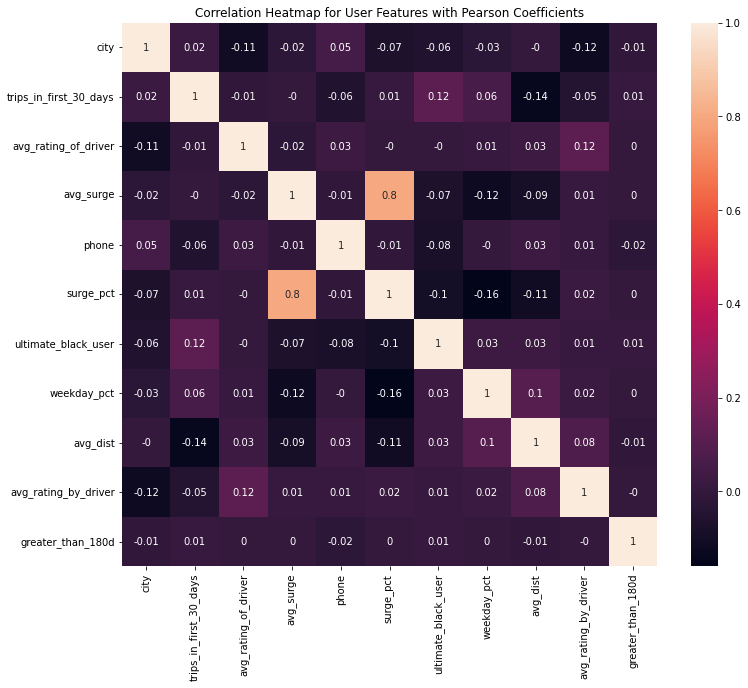

In [61]:
fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(round(udf.corr(), 2), annot=True)
ax.set_title('Correlation Heatmap for User Features with Pearson Coefficients');

Avg_surge and surge_pct have a correlation coefficient of 0.8. 

Avg_surge: avg surge multiplier over all of the user's trips 

Surge_pct: % of trips taken with the surge multiplier > 1

In [64]:
udf.columns

Index(['city', 'trips_in_first_30_days', 'signup_date', 'avg_rating_of_driver',
       'avg_surge', 'last_trip_date', 'phone', 'surge_pct',
       'ultimate_black_user', 'weekday_pct', 'avg_dist',
       'avg_rating_by_driver', 'time', 'greater_than_180d'],
      dtype='object')

The original dataset is too imbalanced, so it will produce an unusable model. We choose 81 random data points from users who stayed less than 180 days to match the 81 from users who stayed more than or equal to 180 days.

In [65]:
from random import sample
sampledf=pd.concat([udf[udf.greater_than_180d==0.].sample(81),udf[udf.greater_than_180d==1.]], ignore_index=True)

In [66]:
sampledf.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,time,greater_than_180d
0,2.0,4,2014-01-04,4.3,1.30,2014-03-30,1.0,60.0,0.0,0.0,5.44,5.0,85 days,0.0
1,2.0,0,2014-01-14,4.4,1.04,2014-06-24,1.0,16.7,1.0,66.7,5.24,4.8,161 days,0.0
2,2.0,3,2014-01-21,4.0,1.17,2014-06-09,0.0,16.7,1.0,83.3,14.93,5.0,139 days,0.0
3,1.0,1,2014-01-02,5.0,1.00,2014-01-02,0.0,0.0,1.0,100.0,2.81,5.0,0 days,0.0
4,1.0,3,2014-01-17,4.7,1.25,2014-01-19,0.0,33.3,0.0,0.0,2.72,4.3,2 days,0.0


In [67]:
sampledf.shape

(162, 14)

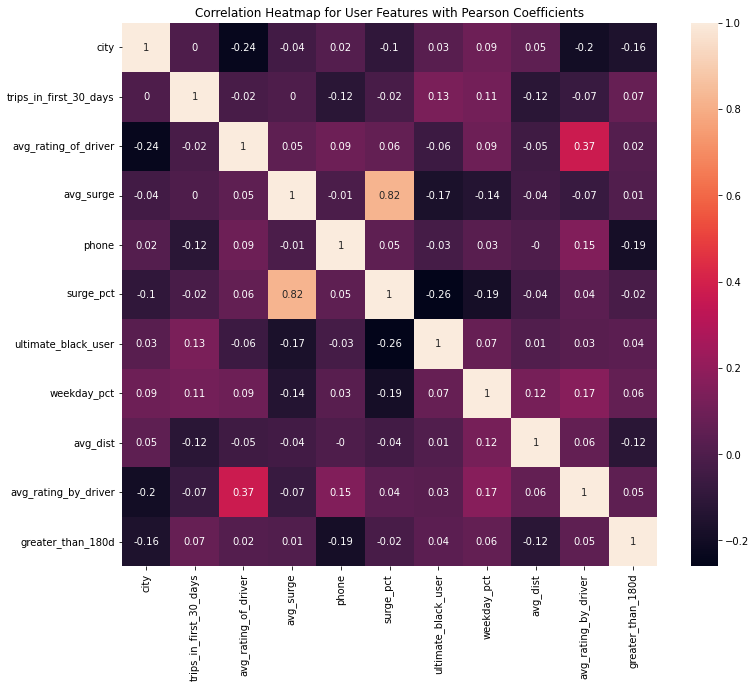

In [92]:
fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(round(sampledf.corr(), 2), annot=True)
ax.set_title('Correlation Heatmap for User Features with Pearson Coefficients');

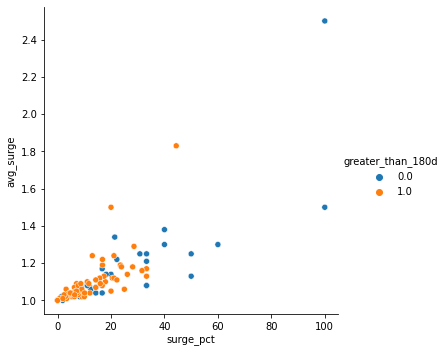

In [91]:
sns.relplot(x='surge_pct', y='avg_surge', hue='greater_than_180d', data=sampledf)
plt.show()

It seems like those who were active for greater than 180 days took less trips on a surge multiplier. Average rating by the driver and of the driver had a slight correlation of 0.37 which does make sense as it is oftentimes the rating of the interaction between the driver and rider.

In [88]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, precision_recall_curve, classification_report, confusion_matrix, ConfusionMatrixDisplay 

In [69]:
cols=['city', 'trips_in_first_30_days', 'avg_rating_of_driver', 'avg_surge', 'phone', 'surge_pct', 'ultimate_black_user', 'weekday_pct', 'avg_dist', 'avg_rating_by_driver']
X=sampledf[cols]
y=sampledf[['greater_than_180d']].values.ravel()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=16)

In [70]:
scaler=MinMaxScaler().fit(X_train)
X_train_scaled=scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test)

In [71]:
rf=RandomForestClassifier(random_state=16)
param_grid={'n_estimators':[10, 50, 100, 300, 500, 700, 1000],
            'criterion':['gini', 'entropy'],
            'max_features':['sqrt', 'log2'],
            'max_depth':[None, 1, 3, 5, 7, 15, 30]}
rf_cv=GridSearchCV(rf, param_grid, scoring='roc_auc', cv=10)
rf_cv.fit(X_train_scaled, y_train)
print("Tuned Logistic Regression Parameter: {}".format(rf_cv.best_params_))
print("Tuned Logistic Regression Score: {}".format(rf_cv.best_score_))

Tuned Logistic Regression Parameter: {'criterion': 'gini', 'max_depth': 3, 'max_features': 'sqrt', 'n_estimators': 50}
Tuned Logistic Regression Score: 0.8395833333333333


In [80]:
clf=RandomForestClassifier(criterion='gini', max_depth=3, max_features='sqrt', n_estimators=50, random_state=16)
clf.fit(X_train_scaled, y_train)
y_pred=clf.predict(X_test_scaled)
y_pred_prob=clf.predict_proba(X_test_scaled)[:,1]
fpr, tpr, thresholds=roc_curve(y_test, y_pred_prob)

In [81]:
feature_scores=pd.Series(clf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
feature_scores

surge_pct                 0.227547
trips_in_first_30_days    0.143518
avg_surge                 0.129124
avg_rating_of_driver      0.110919
city                      0.108834
avg_rating_by_driver      0.092630
avg_dist                  0.079689
weekday_pct               0.066033
phone                     0.024325
ultimate_black_user       0.017382
dtype: float64

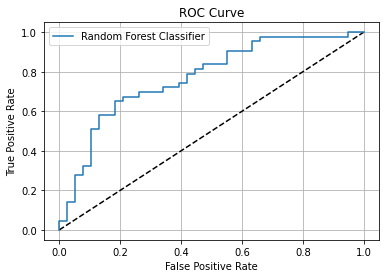

In [82]:
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr, tpr, label='Random Forest Classifier') 
plt.grid()
plt.xlabel('False Positive Rate') 
plt.ylabel('True Positive Rate')
plt.title('ROC Curve') 
plt.legend()
plt.show()

In [83]:
import shap

In [84]:
explainer=shap.TreeExplainer(clf)
shap_values=explainer.shap_values(X_test)

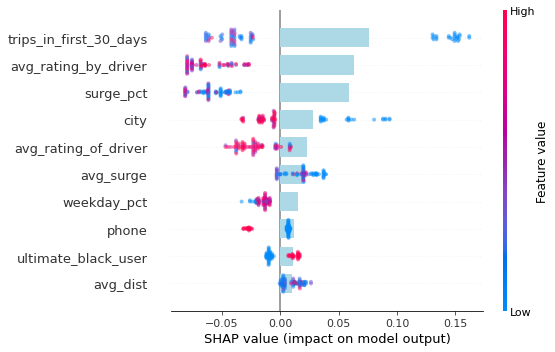

In [85]:
plt.figure(figsize=(8,5))
shap.summary_plot(shap_values[1], X_test, plot_type='bar', color='lightblue', plot_size=None, show=False)
shap.summary_plot(shap_values[1], X_test, plot_size=None, show=False, alpha=0.5)
plt.show()

Feature importances show that users were most likely to be long-term users if:
1. the user took more trips in the first 30 days
2. had a higher average rating by the driver
3. traveled without a surge multiplier

Users should be alerted with reminder notifications from the app more frequently in the first 30 days and on weekends. Further, if the business model can be altered in a way that accounts for a promo code in these first 30 days or the surge multiplier is accounted for, the service will attract long-term users. 

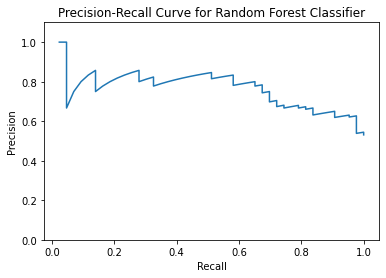

In [86]:
precision, recall, threshold = precision_recall_curve(y_test, y_pred_prob)
fig, ax=plt.subplots()
ax.plot(recall[:-1], precision[:-1])
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('Precision-Recall Curve for Random Forest Classifier')
ax.set_ylim(0.0, 1.1)
plt.show()

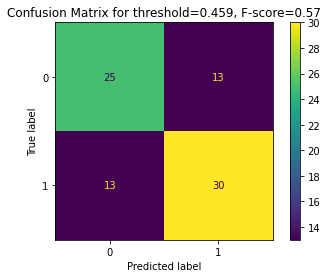

              precision    recall  f1-score   support

         0.0       0.66      0.66      0.66        38
         1.0       0.70      0.70      0.70        43

    accuracy                           0.68        81
   macro avg       0.68      0.68      0.68        81
weighted avg       0.68      0.68      0.68        81



In [89]:
cm=confusion_matrix(y_test, y_pred)
disp=ConfusionMatrixDisplay(cm)
disp.plot()
plt.grid(False)
plt.title('Confusion Matrix for threshold=0.459, F-score=0.57')
plt.show()
print(classification_report(y_test, y_pred))

We are able to predict whether or not a user will be active in their 6th month on the system with 0.7 recall and precision. We can achieve higher recall and precision if we have more data.